In [26]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
import re
import html

def spec_add_spaces(t: str) -> str:
    "Add spaces around / and # in `t`. \n"
    return re.sub(r"([/#\n])", r" \1 ", t)

def rm_useless_spaces(t: str) -> str:
    "Remove multiple spaces in `t`."
    return re.sub(" {2,}", " ", t)

def replace_multi_newline(t: str) -> str:
    return re.sub(r"(\n(\s)*){2,}", "\n", t)

def fix_html(x: str) -> str:
    "List of replacements from html strings in `x`."
    re1 = re.compile(r"  +")
    x = (
        x.replace("#39;", "'")
        .replace("amp;", "&")
        .replace("#146;", "'")
        .replace("nbsp;", " ")
        .replace("#36;", "$")
        .replace("\\n", "\n")
        .replace("quot;", "'")
        .replace("<br />", "\n")
        .replace('\\"', '"')
        .replace(" @.@ ", ".")
        .replace(" @-@ ", "-")
        .replace(" @,@ ", ",")
        .replace("\\", " \\ ")
    )
    return re1.sub(" ", html.unescape(x))

def clean_text(input_text):
    text = fix_html(input_text)
    text = replace_multi_newline(text)
    text = spec_add_spaces(text)
    text = rm_useless_spaces(text)
    text = text.strip()
    return text

In [29]:
import pandas as pd
import nltk
nltk.download('punkt')
from tqdm import tqdm

df = pd.read_csv("KickstarterData.csv")
df = df.dropna(axis = 0)
df["tokenized"] = df["name"].apply(lambda x: nltk.word_tokenize(clean_text(x.lower())))
df = df[(df["state"] == "successful") |(df["state"] == "failed")]
df["hit"] = np.where(df["state"] == "successful", 1, 0)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joshu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
print(df[df["hit"] == 1].shape)
print(df[df["hit"] == 0].shape)

(133851, 17)
(197611, 17)


In [31]:
from collections import Counter
PADDING_VALUE = 0
UNK_VALUE     = 1

def split_train_val_test(df, props=[.8, .1, .1]):
    assert round(sum(props), 2) == 1 and len(props) >= 2
    train_df, test_df, val_df = None, None, None

    first_partition = int(df.shape[0] * props[0])
    second_partition = int(df.shape[0] * (props[0] + props[1]))

    train_df = df.iloc[:first_partition,:]
    val_df = df.iloc[first_partition:second_partition,:]
    test_df = df.iloc[second_partition:,:]
    
    return train_df, val_df, test_df

def generate_vocab_map(df, cutoff=2):
    vocab          = {"": PADDING_VALUE, "UNK": UNK_VALUE}
    reversed_vocab = None

    cnt = {}
    for tokens in df["tokenized"]:
      for word in tokens:
        if (word in cnt):
          cnt[word] = cnt[word] + 1
        else:
          cnt[word] = 1

    reversed_vocab = {}
    reversed_vocab[PADDING_VALUE] = ""
    reversed_vocab[UNK_VALUE] = "UNK"
    int_ID = 2
    for word in cnt:
      if (cnt[word] > cutoff):
        vocab[word] = int_ID
        reversed_vocab[int_ID] = word
        int_ID = int_ID + 1
    
    return vocab, reversed_vocab

In [ ]:
#tst = df[["name","hit"]]

In [ ]:
#tst.columns = ["text", "labels"]

In [ ]:
#df = tst.copy()
#df = df.sample(frac = 0.1)

In [ ]:
#train_df = df[:int(0.8*len(df))]

In [ ]:
#test_df = df[int(0.8*len(df)):]

In [32]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,tokenized,hit
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,"[the, songs, of, adelaide, &, abullah]",0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,"[greeting, from, earth, :, zgac, arts, capsule...",0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,"[where, is, hank, ?]",0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,"[toshicapital, rekordz, needs, help, to, compl...",0
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.00,"[monarch, espresso, bar]",1


In [33]:
df["cat"] = df.category.astype('category').cat.codes
df["cat_bigger"] = df.main_category.astype('category').cat.codes

In [34]:
df                         = df.sample(frac=0.2)
train_df, val_df, test_df  = split_train_val_test(df, props=[.8, .1, .1])
train_vocab, reverse_vocab = generate_vocab_map(train_df)

In [35]:
from torch.utils.data import Dataset

class WordDataset(Dataset):
    
    def __init__(self, vocab, df, max_length=50):
        self.vocab = vocab
        self.df = df
        self.max_length = max_length

        return
    
    # return the length of the dataframe instance variable
    def __len__(self):      
        df_len = self.df.shape[0]
        return df_len

    def __getitem__(self, index: int):
        self.df = self.df.reset_index(drop=True)
        for i in range(len(self.df["tokenized"][index])):
          if not(self.df["tokenized"][index][i] in self.vocab):
            self.df["tokenized"][index][i] = "UNK"

        mapped = []
        for word in self.df["tokenized"][index]:
          if(len(mapped) < self.max_length):
            mapped.append(self.vocab[word])
        mapped.append(self.df["cat"][index]) #added
        mapped.append(self.df["cat_bigger"][index])
        tokenized_word_tensor = torch.LongTensor(mapped)
        tokenized_word_tensor = tokenized_word_tensor.to(torch.device(device))

        curr_label = self.df["hit"][index]

        return tokenized_word_tensor, curr_label


In [36]:
from torch.utils.data import RandomSampler

train_dataset = WordDataset(train_vocab, train_df)
val_dataset   = WordDataset(train_vocab, val_df)
test_dataset  = WordDataset(train_vocab, test_df)
 
train_sampler = RandomSampler(train_dataset)
val_sampler   = RandomSampler(val_dataset)
test_sampler  = RandomSampler(test_dataset)

In [37]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch, padding_value=PADDING_VALUE):
    padded_tokens, y_labels = None, None

    ptlist = [] # padded_tokens list version
    ylist = []
    for tup in batch:
      ptlist.append(tup[0])
      ylist.append(tup[1])
    padded_tokens = pad_sequence(ptlist, batch_first = True, padding_value = padding_value)
    y_labels = torch.LongTensor(ylist)
    
    return padded_tokens, y_labels

In [38]:
from torch.utils.data import DataLoader
BATCH_SIZE = 16

train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn)
val_iterator   = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, collate_fn=collate_fn)
test_iterator  = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler, collate_fn=collate_fn)

In [39]:
import torch.nn as nn

class NBOW(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lin_sig = nn.Sequential(
            nn.Linear(embedding_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        embedded = self.embedding_layer(x)
        mean_embed = torch.mean(embedded, axis = 1)
        x_res = self.lin_sig(mean_embed)

        return x_res

In [40]:
model = NBOW(vocab_size = len(train_vocab.keys()), embedding_dim = 300).to(device)

In [41]:
from torch.optim import Adam

criterion = nn.BCELoss().to(torch.device(device))
optimizer = Adam(model.parameters(), lr = 0.003)

In [42]:
def train_loop(model, criterion, optim, iterator):
    model.train()
    total_loss = 0
    for x, y in tqdm(iterator):

        optim.zero_grad()
        loss = criterion(model.forward(x).reshape(y.shape), y.float().to(torch.device(device)))
        total_loss += loss
        loss.backward()
        optim.step()

    return total_loss

def val_loop(model, iterator):
    true, pred = [], []

    for x, y in tqdm(iterator):
      for tv in y:
        if (tv == 0):
          true.append(False)
        elif (tv == 1):
          true.append(True)
      p = model.forward(x)
      for pv in p:
        if (pv <= 0.5):
          pred.append(False)
        else:
          pred.append(True)

    return true, pred

In [43]:
def accuracy(true, pred):
    acc = None

    same = 0
    for i in range(len(true)):
      if(true[i] == pred[i]):
        same += 1
    acc = same / len(true)

    return acc

def binary_f1(true, pred, selected_class=True):
    f1 = None

    tp = 0 # True Positive
    fp = 0 # False Positive. Actually negative, but predicted to positive
    fn = 0 # False Negative. Actually positive, but predicted to negative
    tn = 0 # True Negative.

    for i in range(len(true)):
      if(true[i] == True) and (pred[i] == True):
        tp = tp + 1
      elif(true[i] == True) and (pred[i] == False):
        fn = fn + 1
      elif(true[i] == False) and (pred[i] == True):
        fp = fp + 1
      elif(true[i] == False) and (pred[i] == False):
        tn = tn + 1
    
    if(selected_class == True):
      precision = tp / (tp + fp + 1)
      recall = tp / (tp + fn + 1)
    elif(selected_class == False):
      precision = tn / (tn + fn + 1)
      recall = tn / (tn + fp + 1)

    f1 = 2 * (precision*recall) / (precision + recall + 1e-10) #prevent zerodivision

    return f1

def binary_macro_f1(true, pred):
    averaged_macro_f1 = 0.5*(binary_f1(true, pred, selected_class=True) + binary_f1(true, pred, selected_class=False))
    return averaged_macro_f1

In [45]:
accuracy_plot = []
TOTAL_EPOCHS = 5
for epoch in range(TOTAL_EPOCHS):
    train_loss = train_loop(model, criterion, optimizer, train_iterator)
    true, pred = val_loop(model, val_iterator)
    accuracy_plot.append(accuracy(true, pred))
    print(f"EPOCH: {epoch}")
    print(f"TRAIN LOSS: {train_loss}")
    print(f"VAL F-1: {binary_macro_f1(true, pred)}")
    print(f"VAL ACC: {accuracy(true, pred)}")

100%|██████████| 415/415 [00:04<00:00, 88.29it/s]


EPOCH: 0
TRAIN LOSS: 1920.577392578125
VAL F-1: 0.6055124955623026
VAL ACC: 0.658470357519988


100%|██████████| 415/415 [00:04<00:00, 93.93it/s]


EPOCH: 1
TRAIN LOSS: 1849.52685546875
VAL F-1: 0.6320528931384379
VAL ACC: 0.6562075727862423


100%|██████████| 415/415 [00:04<00:00, 90.80it/s]


EPOCH: 2
TRAIN LOSS: 1805.3619384765625
VAL F-1: 0.6193554344917712
VAL ACC: 0.6524362648966662


100%|██████████| 415/415 [00:04<00:00, 87.65it/s]


EPOCH: 3
TRAIN LOSS: 1772.91845703125
VAL F-1: 0.6241446296218112
VAL ACC: 0.6495700709005883


100%|██████████| 415/415 [00:04<00:00, 92.36it/s]

EPOCH: 4
TRAIN LOSS: 1750.6793212890625
VAL F-1: 0.6205284219219879
VAL ACC: 0.6497209232161714


In [46]:
df[df["hit"] == 1].shape

(26802, 19)

In [47]:
df.shape

(66292, 19)

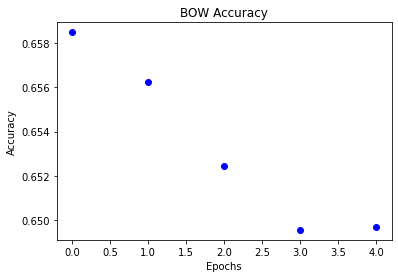

In [50]:
epochs = [range(0, TOTAL_EPOCHS)]
fig = plt.figure()
plt.title('BOW Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.scatter(epochs, accuracy_plot, color = 'blue')
plt.show()

# LSTM model

In [51]:
class RecurrentModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, \
                 num_layers=1, bidirectional=True):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = 0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = num_layers, bidirectional = bidirectional)
        self.lin_sig = nn.Sequential(
            nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = torch.transpose(embedded, 0, 1)

        outputs, (h, c) = self.lstm(embedded)

        predictions = self.lin_sig(outputs)
        predictions = torch.mean(predictions, axis = 0)
        predictions = predictions.reshape((-1,))

        return predictions
    

In [52]:
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn)
val_iterator   = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, collate_fn=collate_fn)
test_iterator  = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler, collate_fn=collate_fn)

In [53]:
lstm_model = RecurrentModel(vocab_size    = len(train_vocab.keys()),
                            embedding_dim = 300,
                            hidden_dim    = 300,
                            num_layers    = 1,
                            bidirectional = True).to(device)

In [54]:
lstm_criterion = nn.BCELoss().to(torch.device(device))
lstm_optimizer = Adam(lstm_model.parameters(), lr=0.003)

In [55]:
accuracy_plot = []
TOTAL_EPOCHS = 30
for epoch in range(TOTAL_EPOCHS):
    train_loss = train_loop(lstm_model, lstm_criterion, lstm_optimizer, train_iterator)
    true, pred = val_loop(lstm_model, val_iterator)
    accuracy_plot.append(accuracy(true, pred))
    print(f"EPOCH: {epoch}")
    print(f"TRAIN LOSS: {train_loss}")
    print(f"VAL F-1: {binary_macro_f1(true, pred)}")
    print(f"VAL ACC: {accuracy(true, pred)}")

100%|██████████| 415/415 [00:04<00:00, 84.42it/s]


EPOCH: 0
TRAIN LOSS: 2047.7359619140625
VAL F-1: 0.6164149216640631
VAL ACC: 0.665409564036808


100%|██████████| 415/415 [00:04<00:00, 92.25it/s] 


EPOCH: 1
TRAIN LOSS: 1861.25146484375
VAL F-1: 0.63819482485699
VAL ACC: 0.662090813093981


100%|██████████| 415/415 [00:04<00:00, 89.52it/s] 


EPOCH: 2
TRAIN LOSS: 1660.4942626953125
VAL F-1: 0.6368926721922209
VAL ACC: 0.658470357519988


100%|██████████| 415/415 [00:04<00:00, 94.57it/s] 


EPOCH: 3
TRAIN LOSS: 1463.2650146484375
VAL F-1: 0.6268851334932394
VAL ACC: 0.6530396741589983


100%|██████████| 415/415 [00:04<00:00, 92.76it/s]


EPOCH: 4
TRAIN LOSS: 1283.9573974609375
VAL F-1: 0.6347109941519958
VAL ACC: 0.6527379695278323


100%|██████████| 415/415 [00:06<00:00, 65.03it/s] 


EPOCH: 5
TRAIN LOSS: 1156.12646484375
VAL F-1: 0.6194408815360468
VAL ACC: 0.6406697842811887


100%|██████████| 415/415 [00:04<00:00, 98.88it/s] 


EPOCH: 6
TRAIN LOSS: 1051.05224609375
VAL F-1: 0.6188156336423194
VAL ACC: 0.6355408055513652


100%|██████████| 415/415 [00:04<00:00, 87.56it/s] 


EPOCH: 7
TRAIN LOSS: 973.9048461914062
VAL F-1: 0.621446169225731
VAL ACC: 0.6400663750188565


100%|██████████| 415/415 [00:04<00:00, 83.39it/s]


EPOCH: 8
TRAIN LOSS: 920.9381103515625
VAL F-1: 0.6116149557411718
VAL ACC: 0.6286015990345452


100%|██████████| 415/415 [00:04<00:00, 95.53it/s] 


EPOCH: 9
TRAIN LOSS: 887.7551879882812
VAL F-1: 0.6108568074617389
VAL ACC: 0.6264896666163826


100%|██████████| 415/415 [00:04<00:00, 93.80it/s] 


EPOCH: 10
TRAIN LOSS: 866.7791748046875
VAL F-1: 0.6139052795472678
VAL ACC: 0.6287524513501282


100%|██████████| 415/415 [00:04<00:00, 94.47it/s]


EPOCH: 11
TRAIN LOSS: 832.0557250976562
VAL F-1: 0.6165231834530753
VAL ACC: 0.6387087041786091


100%|██████████| 415/415 [00:04<00:00, 92.47it/s] 


EPOCH: 12
TRAIN LOSS: 817.2713623046875
VAL F-1: 0.6083969734019499
VAL ACC: 0.6302609745059586


100%|██████████| 415/415 [00:04<00:00, 91.76it/s] 


EPOCH: 13
TRAIN LOSS: 810.9959106445312
VAL F-1: 0.6044046283788675
VAL ACC: 0.6231709156735555


100%|██████████| 415/415 [00:04<00:00, 98.11it/s] 


EPOCH: 14
TRAIN LOSS: 786.3110961914062
VAL F-1: 0.6038387545344126
VAL ACC: 0.6219640971488912


100%|██████████| 415/415 [00:04<00:00, 96.28it/s] 


EPOCH: 15
TRAIN LOSS: 777.151123046875
VAL F-1: 0.6067415575365107
VAL ACC: 0.6228692110423895


100%|██████████| 415/415 [00:04<00:00, 96.64it/s] 


EPOCH: 16
TRAIN LOSS: 772.574462890625
VAL F-1: 0.6055621754380542
VAL ACC: 0.62437773419822


100%|██████████| 415/415 [00:04<00:00, 89.23it/s] 


EPOCH: 17
TRAIN LOSS: 763.4066162109375
VAL F-1: 0.6061626601959281
VAL ACC: 0.6222658017800573


100%|██████████| 415/415 [00:04<00:00, 91.75it/s] 


EPOCH: 18
TRAIN LOSS: 759.4066772460938
VAL F-1: 0.6063978940373541
VAL ACC: 0.6281490420877961


100%|██████████| 415/415 [00:04<00:00, 90.50it/s] 


EPOCH: 19
TRAIN LOSS: 747.79931640625
VAL F-1: 0.5986627795795133
VAL ACC: 0.6163825614723186


100%|██████████| 415/415 [00:04<00:00, 86.39it/s]


EPOCH: 20
TRAIN LOSS: 729.5053100585938
VAL F-1: 0.6016580538057763
VAL ACC: 0.6216623925177251


100%|██████████| 415/415 [00:04<00:00, 90.93it/s] 


EPOCH: 21
TRAIN LOSS: 727.8342895507812
VAL F-1: 0.5970959829404474
VAL ACC: 0.6156282998944034


100%|██████████| 415/415 [00:04<00:00, 92.61it/s] 


EPOCH: 22
TRAIN LOSS: 741.1114501953125
VAL F-1: 0.5933866571981077
VAL ACC: 0.6108010257957459


100%|██████████| 415/415 [00:04<00:00, 87.31it/s]


EPOCH: 23
TRAIN LOSS: 754.28173828125
VAL F-1: 0.5970959829404474
VAL ACC: 0.6156282998944034


100%|██████████| 415/415 [00:04<00:00, 89.04it/s]


EPOCH: 24
TRAIN LOSS: 720.036865234375
VAL F-1: 0.6021560688553048
VAL ACC: 0.621209835570976


100%|██████████| 415/415 [00:04<00:00, 91.45it/s] 


EPOCH: 25
TRAIN LOSS: 684.834716796875
VAL F-1: 0.6073981648091525
VAL ACC: 0.6264896666163826


100%|██████████| 415/415 [00:04<00:00, 86.86it/s] 


EPOCH: 26
TRAIN LOSS: 700.213134765625
VAL F-1: 0.5973726395721815
VAL ACC: 0.6153265952632373


100%|██████████| 415/415 [00:04<00:00, 87.92it/s]


EPOCH: 27
TRAIN LOSS: 699.8583984375
VAL F-1: 0.6062230684232583
VAL ACC: 0.6200030170463117


100%|██████████| 415/415 [00:04<00:00, 88.73it/s] 


EPOCH: 28
TRAIN LOSS: 700.6678466796875
VAL F-1: 0.5984888232543943
VAL ACC: 0.6192487554683964


100%|██████████| 415/415 [00:04<00:00, 87.19it/s]

EPOCH: 29
TRAIN LOSS: 724.4766845703125
VAL F-1: 0.6006307368908215
VAL ACC: 0.617740232312566


100%|██████████| 415/415 [00:05<00:00, 80.75it/s]



TEST F-1: 0.6128721402934387
TEST ACC: 0.6301659125188537


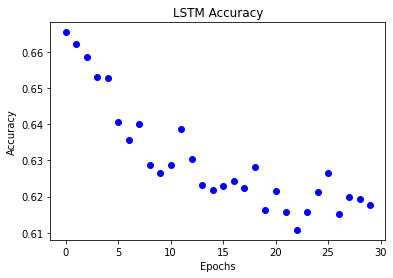

In [56]:
true, pred = val_loop(lstm_model, test_iterator)
print()
print(f"TEST F-1: {binary_macro_f1(true, pred)}")
print(f"TEST ACC: {accuracy(true, pred)}")
epochs = [range(0, TOTAL_EPOCHS)]
fig = plt.figure()
plt.title('LSTM Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.scatter(epochs, accuracy_plot, color = 'blue')
plt.show()

# Transformer

In [60]:
!pip install wandb
!pip install simpletransformers

In [61]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

In [63]:
model_args = ClassificationArgs(num_train_epochs=5)

# Create a ClassificationModel
model = ClassificationModel(
    "roberta", "roberta-base", args=model_args
)

# Train the model
model.train_model(train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(test_df)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

ValueError: too many dimensions 'str'

In [ ]:
result

{'mcc': 0.2036990814017142,
 'tp': 165,
 'tn': 236,
 'fp': 148,
 'fn': 114,
 'auroc': 0.6203843712664278,
 'auprc': 0.5543358636748549,
 'eval_loss': 1.3236708993832749}